In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, avg, when, month, year
from pyspark.sql.window import Window
import matplotlib.pyplot as plt

In [2]:
# Initialize Spark session
spark = SparkSession.builder.appName("usecase").getOrCreate()

In [3]:
# Load the dataset
df = spark.read.csv("real_estate_dataset.csv", header=True, inferSchema=True)

In [4]:
df.show()

+-----------+-----------+-------------+------------+------------------+------------------+--------------------+-----------------+------------------+-----------+
|property_id|   location|property_type|num_bedrooms|     num_bathrooms|             price|           amenities|availability_date|            rating|is_verified|
+-----------+-----------+-------------+------------+------------------+------------------+--------------------+-----------------+------------------+-----------+
|          1|Countryside|        Condo|           2|1.3998082914496786| 2853.984713195897|       Swimming Pool|       2024-12-09|4.4794641644429865|       true|
|          2|   Downtown|        House|           4|2.4742481456267935| 3566.860962623556|                 Gym|       2024-12-11|3.0261248662082867|      false|
|          3|Countryside|        House|           2| 2.775018522113835| 3157.461075378968|Parking, Pet Frie...|       2024-07-03|3.6793462596245243|       true|
|          4|Countryside|    Apart

In [5]:
df.printSchema()

root
 |-- property_id: integer (nullable = true)
 |-- location: string (nullable = true)
 |-- property_type: string (nullable = true)
 |-- num_bedrooms: integer (nullable = true)
 |-- num_bathrooms: double (nullable = true)
 |-- price: double (nullable = true)
 |-- amenities: string (nullable = true)
 |-- availability_date: date (nullable = true)
 |-- rating: double (nullable = true)
 |-- is_verified: boolean (nullable = true)



# Task 2: Data Cleaning and Exploration

In [8]:

df.describe("price").show()
df = df.filter(col("price").isNotNull())

+-------+------------------+
|summary|             price|
+-------+------------------+
|  count|             10000|
|   mean| 2985.977237523862|
| stddev| 1150.404354128771|
|    min|1000.4094901033875|
|    max| 4999.895470585027|
+-------+------------------+



# Task 3: Occupancy Rate Analysis

In [9]:
overall_occupancy_rate = df.select(avg(when(col("is_verified") == True, 1).otherwise(0))).collect()[0][0]

overall_occupancy_rate

0.5068

In [10]:
from pyspark.sql.functions import avg, when

In [11]:
bedroom_occupancy_rates = (
    df.withColumn("is_verified_numeric", when(df["is_verified"], 1).otherwise(0))
    .groupBy("num_bedrooms")
    .agg(avg("is_verified_numeric").alias("occupancy_rate"))
)

bedroom_occupancy_rates.show()

+------------+------------------+
|num_bedrooms|    occupancy_rate|
+------------+------------------+
|           1|0.4866504854368932|
|           3|0.5146222583265637|
|           4|0.5045472518782127|
|           2|0.5210878990934175|
+------------+------------------+



In [12]:
from pyspark.sql import functions as F

In [14]:
top_property_types = (
    df.groupBy("property_type")
    .agg((F.sum(F.col("is_verified").cast("int")) / F.count("*")).alias("occupancy_rate"))
    .orderBy("occupancy_rate", ascending=False)
    .limit(3)
)


top_property_types.show()

+-------------+------------------+
|property_type|    occupancy_rate|
+-------------+------------------+
|        Condo|0.5110706703063391|
|        House|0.5070507050705071|
|    Apartment| 0.502373887240356|
+-------------+------------------+



# Task 4: Price Distribution Analysis

In [15]:
price_distribution = df.select("price").toPandas()

price_distribution

,price
0,2853.984713
1,3566.860963
2,3157.461075
3,1635.590050
4,3357.092122
...,...
9995,1969.858364
9996,4633.679849
9997,3460.436278
9998,3669.504429


In [16]:
avg_price_per_type_location = df.groupBy("property_type", "location").agg(avg("price").alias("avg_price"))

avg_price_per_type_location.show()

+-------------+-----------+------------------+
|property_type|   location|         avg_price|
+-------------+-----------+------------------+
|        Condo|     Suburb| 3072.676402106759|
|        Condo|   Downtown|3008.2686693712108|
|    Apartment|Countryside|3034.1721449641173|
|    Apartment|     Suburb|2956.5745459134037|
|        House|Countryside|2980.6103423883023|
|    Apartment|   Downtown| 2935.732253619919|
|        House|     Suburb| 2974.919522380806|
|        House|   Downtown| 2945.005392308668|
|        Condo|Countryside| 2967.808479239524|
+-------------+-----------+------------------+



In [17]:
price_bedroom_correlation = df.groupBy("num_bedrooms").agg(avg("price").alias("avg_price"))

price_bedroom_correlation.show()

+------------+------------------+
|num_bedrooms|         avg_price|
+------------+------------------+
|           1| 2964.619288077803|
|           3| 3024.955637235642|
|           4| 2972.154556085609|
|           2|2982.7409711847276|
+------------+------------------+



# Task 5: Temporal Analysis

In [18]:
df = df.withColumn("availability_month", month("availability_date"))

df.show()

+-----------+-----------+-------------+------------+------------------+------------------+--------------------+-----------------+------------------+-----------+------------------+
|property_id|   location|property_type|num_bedrooms|     num_bathrooms|             price|           amenities|availability_date|            rating|is_verified|availability_month|
+-----------+-----------+-------------+------------+------------------+------------------+--------------------+-----------------+------------------+-----------+------------------+
|          1|Countryside|        Condo|           2|1.3998082914496786| 2853.984713195897|       Swimming Pool|       2024-12-09|4.4794641644429865|       true|                12|
|          2|   Downtown|        House|           4|2.4742481456267935| 3566.860962623556|                 Gym|       2024-12-11|3.0261248662082867|      false|                12|
|          3|Countryside|        House|           2| 2.775018522113835| 3157.461075378968|Parking, P

In [19]:
availability_trends = df.groupBy("availability_month").agg(count("property_id").alias("availability_count"))

availability_trends.show()

+------------------+------------------+
|availability_month|availability_count|
+------------------+------------------+
|                12|               895|
|                 1|               798|
|                 6|               821|
|                 3|               867|
|                 5|               886|
|                 9|               799|
|                 4|               816|
|                 8|               825|
|                 7|               850|
|                10|               841|
|                11|               849|
|                 2|               753|
+------------------+------------------+



# Task 6: Location-Based Insights

In [20]:
location_insights = (
    df.groupBy("location")
    .agg(
        F.avg("price").alias("avg_price"),
        F.avg(F.col("is_verified").cast("int")).alias("occupancy_rate")
    )
    .orderBy("avg_price", ascending=False)
    .limit(1)
)

location_insights.show()

+--------+-----------------+------------------+
|location|        avg_price|    occupancy_rate|
+--------+-----------------+------------------+
|  Suburb|3000.786439792036|0.5115028383627129|
+--------+-----------------+------------------+



# Task 7: Rating and Price Relationship

In [21]:
rating_price_relationship = df.groupBy("rating").agg(avg("price").alias("avg_price"))

rating_price_relationship.show()

+------------------+------------------+
|            rating|         avg_price|
+------------------+------------------+
| 3.165694344034847|1129.7110916947584|
|3.5270512731016574|2045.8033950693882|
| 3.477115709963238|2073.8027883535033|
| 4.026787956612232|1480.0962070916416|
|3.5706183230325466|1712.3466723833776|
|3.5883527084111577| 2268.300801576883|
| 4.459699319555169|  2196.21644216261|
|4.1952716240386065| 2437.018998881391|
|3.3824944982032554| 4686.516429590889|
| 4.701190749652316| 3458.090611120116|
| 4.481926989091521|2918.8635796652125|
| 4.950502779493372|2037.0172081822768|
| 4.389129405382019|3388.2759401184344|
|  3.54653337308875|4029.3078201397248|
| 3.591177744054016|4010.8376518830382|
|3.9120403786420637| 2244.548213899839|
|  4.02023655975529| 4497.656001050813|
|4.4369369672712695| 4183.452789766912|
|3.5788460365960173|2019.9374362385406|
| 3.245005732883257| 4914.464852496884|
+------------------+------------------+
only showing top 20 rows



# Task 8: Verification Status Impact

In [22]:
verification_impact = df.groupBy("is_verified").agg(avg("price").alias("avg_price_difference"))

verification_impact.show()

+-----------+--------------------+
|is_verified|avg_price_difference|
+-----------+--------------------+
|       true|  2989.9651873294106|
|      false|  2981.8793199215706|
+-----------+--------------------+



# Task 9: Amenities Impact Analysis

In [23]:
from pyspark.sql.functions import split, explode

In [24]:
amenities_impact = {
    amenity: df.withColumn(amenity, F.expr(f"array_contains(split(amenities, ', '), '{amenity}')"))
               .groupBy(amenity)
               .agg(F.avg("price").alias("avg_price"))
               .collect()
    for amenity in ["Swimming Pool", "Gym", "Parking", "Balcony", "Pet Friendly"]
}


amenities_impact

{'Swimming Pool': [Row(Swimming Pool=True, avg_price=3003.780477292372),
  Row(Swimming Pool=False, avg_price=2976.5167104187053)],
 'Gym': [Row(Gym=True, avg_price=3006.7354308396766),
  Row(Gym=False, avg_price=2974.956200411312)],
 'Parking': [Row(Parking=True, avg_price=2975.0020185868675),
  Row(Parking=False, avg_price=2991.7555202461617)],
 'Balcony': [Row(Balcony=True, avg_price=2989.537431335117),
  Row(Balcony=False, avg_price=2984.0644200956795)],
 'Pet Friendly': [Row(Pet Friendly=True, avg_price=2988.248115887822),
  Row(Pet Friendly=False, avg_price=2984.7641048967766)]}

# Task 10: Visualizations

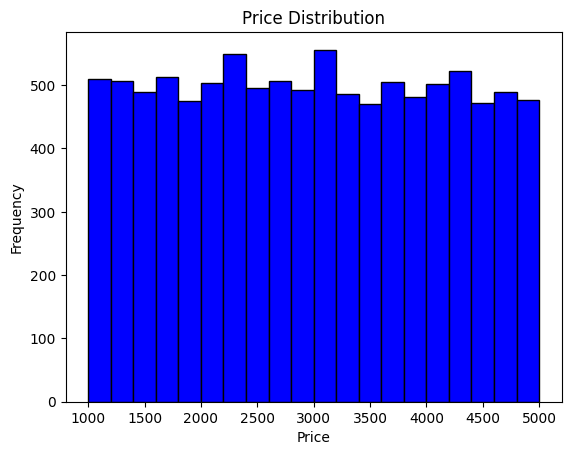

In [25]:
plt.hist(price_distribution['price'], bins=20, color='blue', edgecolor='black')
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

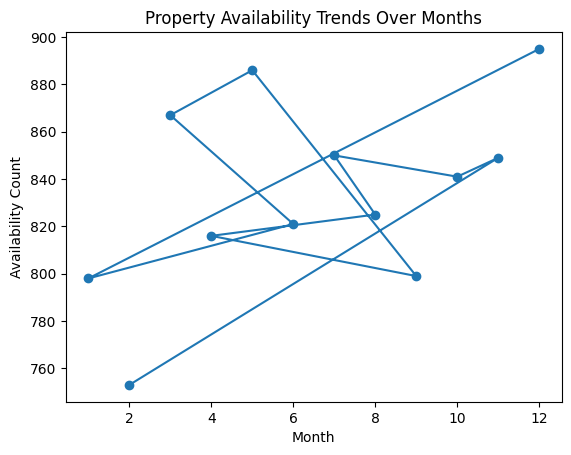

In [26]:
availability_trends_pd = availability_trends.toPandas()
plt.plot(availability_trends_pd['availability_month'], availability_trends_pd['availability_count'], marker='o')
plt.title('Property Availability Trends Over Months')
plt.xlabel('Month')
plt.ylabel('Availability Count')
plt.show()

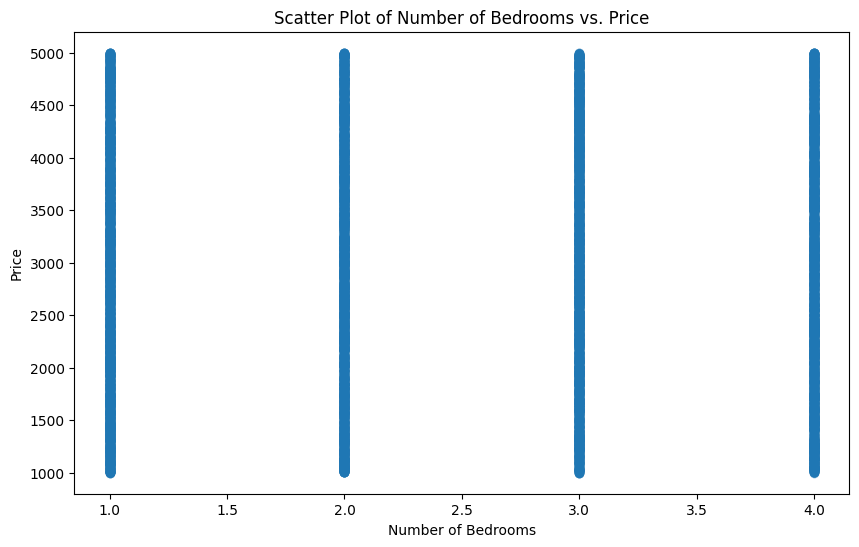

In [27]:
pandas_df = df.select("num_bedrooms", "price").toPandas()

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(pandas_df["num_bedrooms"], pandas_df["price"], alpha=0.5)
plt.title("Scatter Plot of Number of Bedrooms vs. Price")
plt.xlabel("Number of Bedrooms")
plt.ylabel("Price")
plt.show()

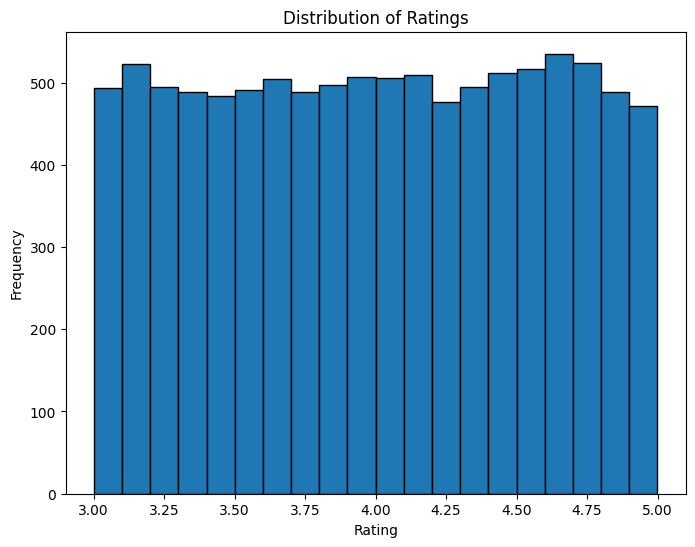

In [28]:
plt.figure(figsize=(8, 6))
plt.hist(df.select("rating").toPandas()["rating"], bins=20, edgecolor='black')
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()


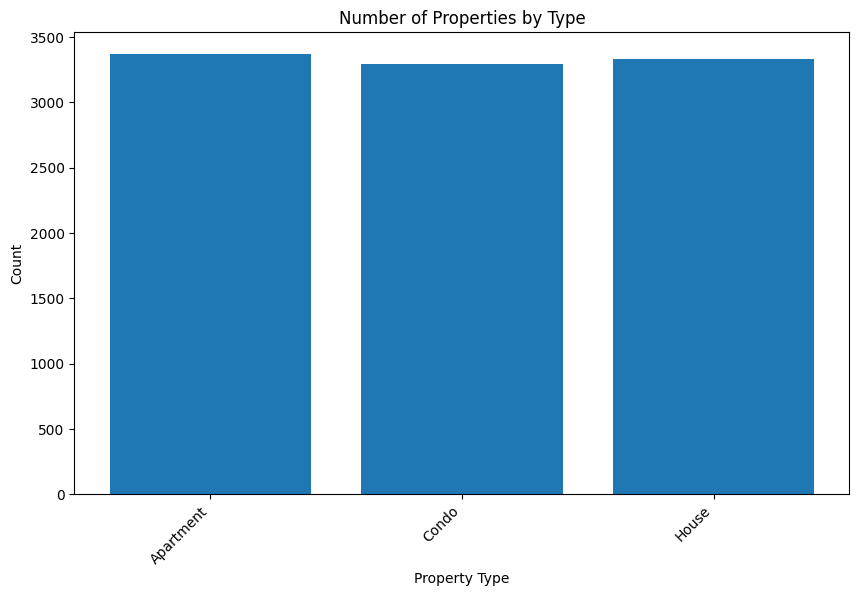

In [29]:
property_type_counts = df.groupBy("property_type").count().toPandas()
plt.figure(figsize=(10, 6))
plt.bar(property_type_counts["property_type"], property_type_counts["count"])
plt.title("Number of Properties by Type")
plt.xlabel("Property Type")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.show()


C:\Users\KarthikKonduru\OneDrive - M S Ratna Global Technologies Private Limited\Documents\pyspark\venv\lib\site-packages\seaborn\categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


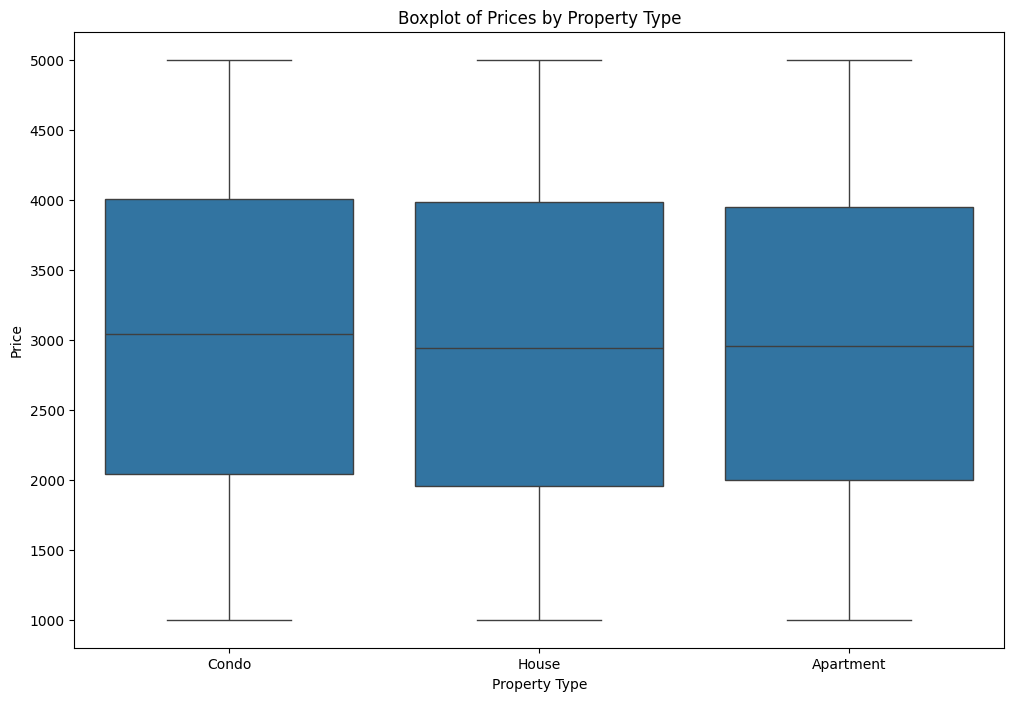

In [30]:
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.boxplot(x="property_type", y="price", data=df.toPandas())
plt.title("Boxplot of Prices by Property Type")
plt.xlabel("Property Type")
plt.ylabel("Price")
plt.show()

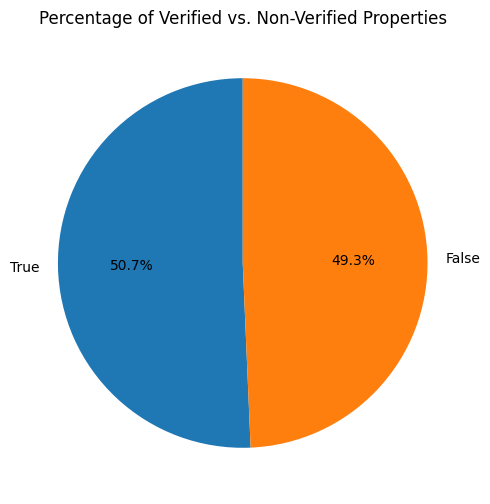

In [31]:
verified_counts = df.groupBy("is_verified").count().toPandas()
plt.figure(figsize=(6, 6))
plt.pie(verified_counts["count"], labels=verified_counts["is_verified"], autopct='%1.1f%%', startangle=90)
plt.title("Percentage of Verified vs. Non-Verified Properties")
plt.show()


In [32]:
#Average Price by Location:

avg_price_by_location = df.groupBy("location").agg(F.avg("price").alias("avg_price")).orderBy("avg_price", ascending=False).toPandas()
print(avg_price_by_location)


      location    avg_price
0       Suburb  3000.786440
1  Countryside  2994.499685
2     Downtown  2962.816250


In [33]:
# Average Price by Property Type:

avg_price_by_property_type = df.groupBy("property_type").agg(F.avg("price").alias("avg_price")).orderBy("avg_price", ascending=False).toPandas()
print(avg_price_by_property_type)

  property_type    avg_price
0         Condo  3016.361630
1     Apartment  2975.363294
2         House  2966.652800


In [34]:
# Number of Properties with Amenities:

properties_with_amenities = df.filter(F.col("amenities").isNotNull()).count()
total_properties = df.count()
percentage_with_amenities = (properties_with_amenities / total_properties) * 100
print(f"Percentage of properties with amenities: {percentage_with_amenities:.2f}%")

Percentage of properties with amenities: 100.00%


In [35]:
# Average Rating by Number of Bedrooms:

avg_rating_by_bedrooms = df.groupBy("num_bedrooms").agg(F.avg("rating").alias("avg_rating")).orderBy("num_bedrooms").toPandas()
print(avg_rating_by_bedrooms)

   num_bedrooms  avg_rating
0             1    4.007690
1             2    3.994890
2             3    3.999189
3             4    4.009495


In [36]:
# Number of Properties Verified vs. Non-Verified:

verified_counts = df.groupBy("is_verified").count().toPandas()
print(verified_counts)


   is_verified  count
0         True   5068
1        False   4932


In [37]:
# Availability of Properties by Month:

availability_by_month = df.groupBy(F.month("availability_date").alias("availability_month")).count().orderBy("availability_month").toPandas()
print(availability_by_month)


    availability_month  count
0                    1    798
1                    2    753
2                    3    867
3                    4    816
4                    5    886
5                    6    821
6                    7    850
7                    8    825
8                    9    799
9                   10    841
10                  11    849
11                  12    895


In [38]:
# Correlation between Numeric Columns:

correlation_matrix = df.select("num_bedrooms", "num_bathrooms", "price", "rating").toPandas().corr()
print(correlation_matrix)

               num_bedrooms  num_bathrooms     price    rating
num_bedrooms       1.000000       0.001576  0.006130  0.001994
num_bathrooms      0.001576       1.000000  0.013312 -0.004052
price              0.006130       0.013312  1.000000  0.007443
rating             0.001994      -0.004052  0.007443  1.000000


In [39]:
# Top N Most Expensive Properties:

top_expensive_properties = df.orderBy("price", ascending=False).limit(5).toPandas()
print(top_expensive_properties)


   property_id     location property_type  num_bedrooms  num_bathrooms  \
0          261     Downtown         Condo             1       1.102319   
1         7948       Suburb         House             4       2.476967   
2         1066  Countryside     Apartment             1       1.639701   
3         2587       Suburb         House             2       1.361799   
4         5462  Countryside         Condo             1       2.641858   

         price                        amenities availability_date    rating  \
0  4999.895471                         Gym, Gym        2024-11-06  4.725608   
1  4999.598737                          Parking        2024-12-02  3.885611   
2  4999.357162                 Parking, Balcony        2024-03-21  4.416290   
3  4999.249552  Swimming Pool, Balcony, Parking        2024-04-13  3.936978   
4  4999.233925            Pet Friendly, Balcony        2024-08-14  4.422323   

   is_verified  availability_month  
0         True                  11  
1     

In [40]:
# Average Price and Rating for Verified vs. Non-Verified Properties:
avg_price_rating_verified = df.groupBy("is_verified").agg(F.avg("price").alias("avg_price"), F.avg("rating").alias("avg_rating")).toPandas()
print(avg_price_rating_verified)

   is_verified    avg_price  avg_rating
0         True  2989.965187    4.001132
1        False  2981.879320    4.004527


In [41]:
# Most Common Amenities:

from pyspark.sql.functions import split, explode

amenities_counts = (
    df.withColumn("amenity", explode(split("amenities", ", ")))
      .groupBy("amenity")
      .count()
      .orderBy("count", ascending=False)
      .toPandas()
)
print(amenities_counts)

         amenity  count
0        Balcony   4010
1  Swimming Pool   3985
2   Pet Friendly   3973
3            Gym   3961
4        Parking   3946


In [42]:
# Average Price by Availability Month:

avg_price_by_month = (
    df.groupBy(F.month("availability_date").alias("availability_month"))
      .agg(F.avg("price").alias("avg_price"))
      .orderBy("availability_month")
      .toPandas()
)
print(avg_price_by_month)

    availability_month    avg_price
0                    1  3053.204976
1                    2  2999.648089
2                    3  2954.676903
3                    4  2991.310383
4                    5  3019.505213
5                    6  2981.213215
6                    7  2945.488492
7                    8  2985.870017
8                    9  3087.723516
9                   10  2942.185554
10                  11  2944.956701
11                  12  2938.952644


In [43]:
# Distribution of Property Types with Swimming Pool:

with_swimming_pool = df.filter("amenities LIKE '%Swimming Pool%'").groupBy("property_type").count().toPandas()
print(with_swimming_pool)


  property_type  count
0     Apartment   1154
1         Condo   1106
2         House   1210


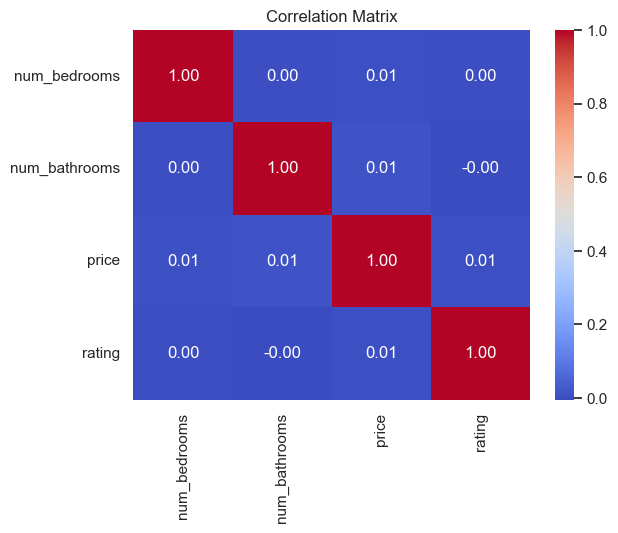

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for seaborn
sns.set(style="whitegrid")

# 1. Correlation Matrix
correlation_matrix = df.select("num_bedrooms", "num_bathrooms", "price", "rating").toPandas().corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

C:\Users\KarthikKonduru\AppData\Local\Temp\ipykernel_5132\1581625218.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="price", y="property_id", data=top_expensive_properties, palette="viridis")
C:\Users\KarthikKonduru\OneDrive - M S Ratna Global Technologies Private Limited\Documents\pyspark\venv\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\KarthikKonduru\OneDrive - M S Ratna Global Technologies Private Limited\Documents\pyspark\venv\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a futur

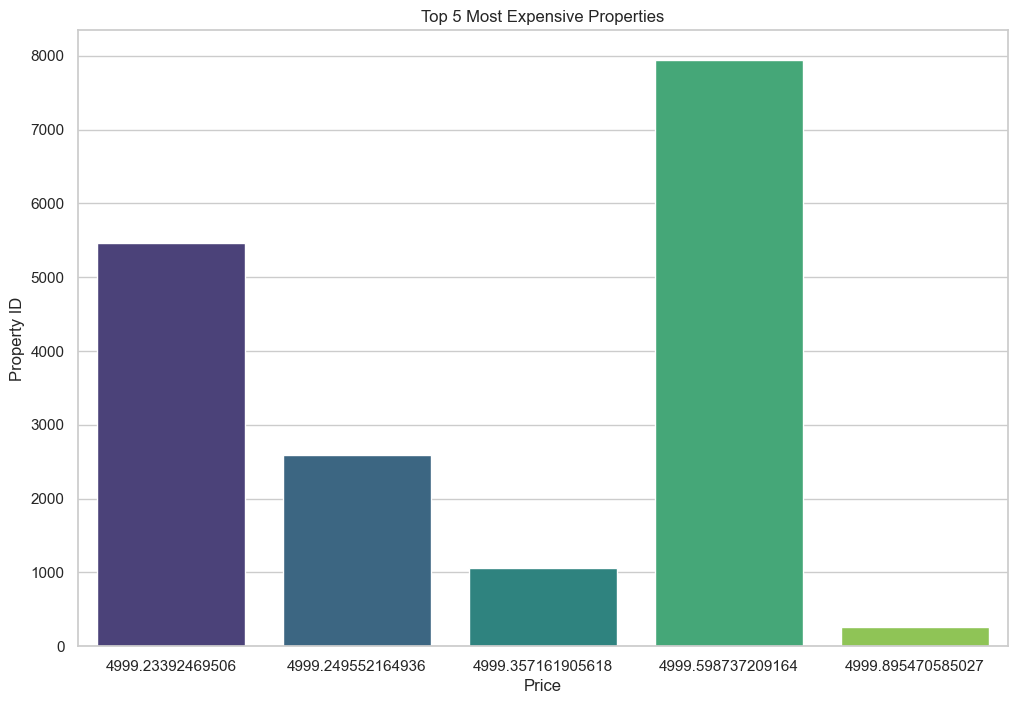

In [45]:
# 2. Top N Most Expensive Properties
top_expensive_properties = df.orderBy("price", ascending=False).limit(5).toPandas()
plt.figure(figsize=(12, 8))
sns.barplot(x="price", y="property_id", data=top_expensive_properties, palette="viridis")
plt.title("Top 5 Most Expensive Properties")
plt.xlabel("Price")
plt.ylabel("Property ID")
plt.show()

C:\Users\KarthikKonduru\AppData\Local\Temp\ipykernel_5132\3592663879.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="count", y="amenity", data=amenities_counts.head(10), palette="muted")
C:\Users\KarthikKonduru\OneDrive - M S Ratna Global Technologies Private Limited\Documents\pyspark\venv\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\KarthikKonduru\OneDrive - M S Ratna Global Technologies Private Limited\Documents\pyspark\venv\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future ve

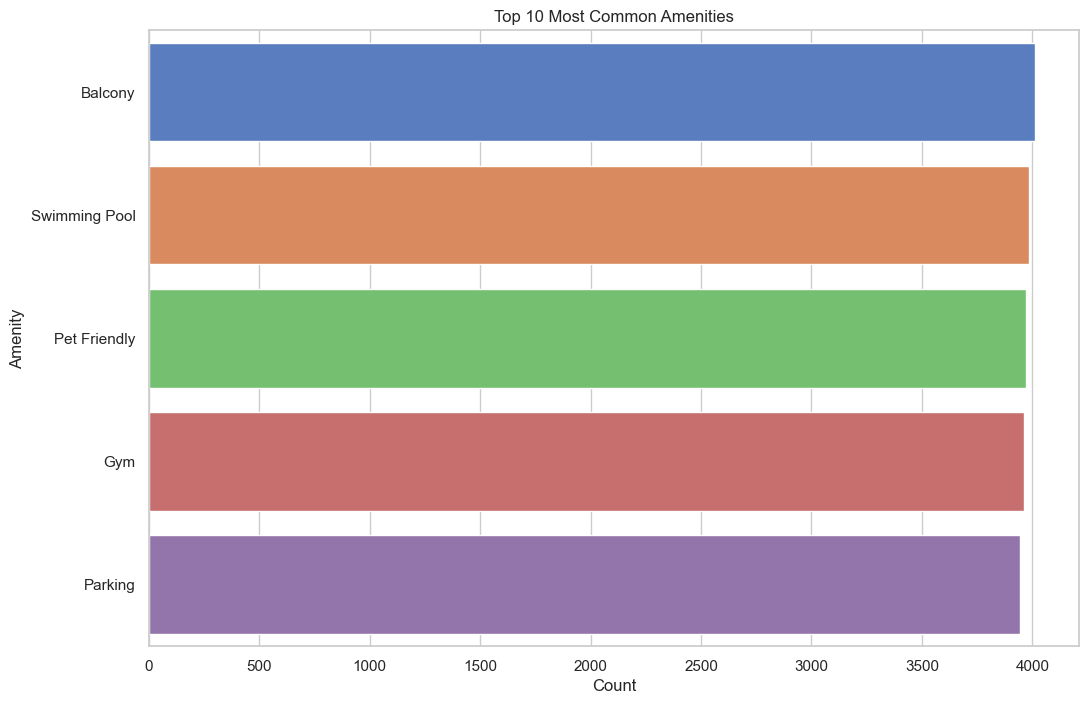

In [46]:
# 4. Most Common Amenities
amenities_counts = (
    df.withColumn("amenity", explode(split("amenities", ", ")))
    .groupBy("amenity")
    .count()
    .orderBy("count", ascending=False)
    .toPandas()
)
plt.figure(figsize=(12, 8))
sns.barplot(x="count", y="amenity", data=amenities_counts.head(10), palette="muted")
plt.title("Top 10 Most Common Amenities")
plt.xlabel("Count")
plt.ylabel("Amenity")
plt.show()

C:\Users\KarthikKonduru\AppData\Local\Temp\ipykernel_5132\2757434320.py:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x="availability_month", y="avg_price", data=avg_price_by_month, marker="o", palette="Blues")


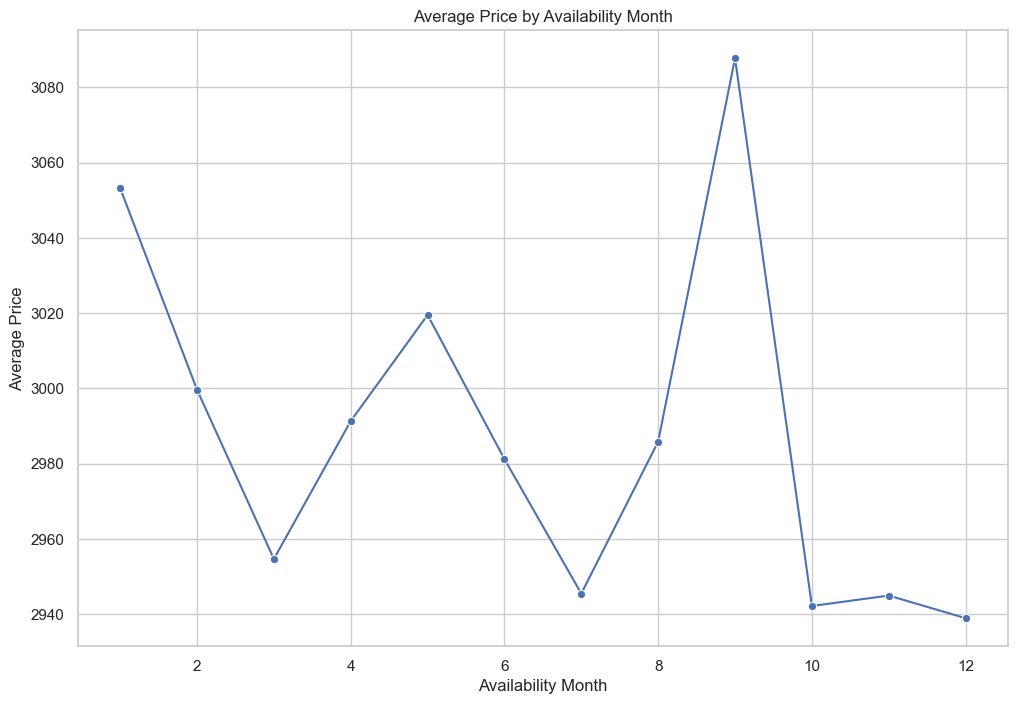

In [47]:
# 5. Average Price by Availability Month
avg_price_by_month = (
    df.groupBy(F.month("availability_date").alias("availability_month"))
    .agg(F.avg("price").alias("avg_price"))
    .orderBy("availability_month")
    .toPandas()
)
plt.figure(figsize=(12, 8))
sns.lineplot(x="availability_month", y="avg_price", data=avg_price_by_month, marker="o", palette="Blues")
plt.title("Average Price by Availability Month")
plt.xlabel("Availability Month")
plt.ylabel("Average Price")
plt.show()

C:\Users\KarthikKonduru\AppData\Local\Temp\ipykernel_5132\610404104.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="count", y="property_type", data=with_swimming_pool, palette="pastel")
C:\Users\KarthikKonduru\OneDrive - M S Ratna Global Technologies Private Limited\Documents\pyspark\venv\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\KarthikKonduru\OneDrive - M S Ratna Global Technologies Private Limited\Documents\pyspark\venv\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future vers

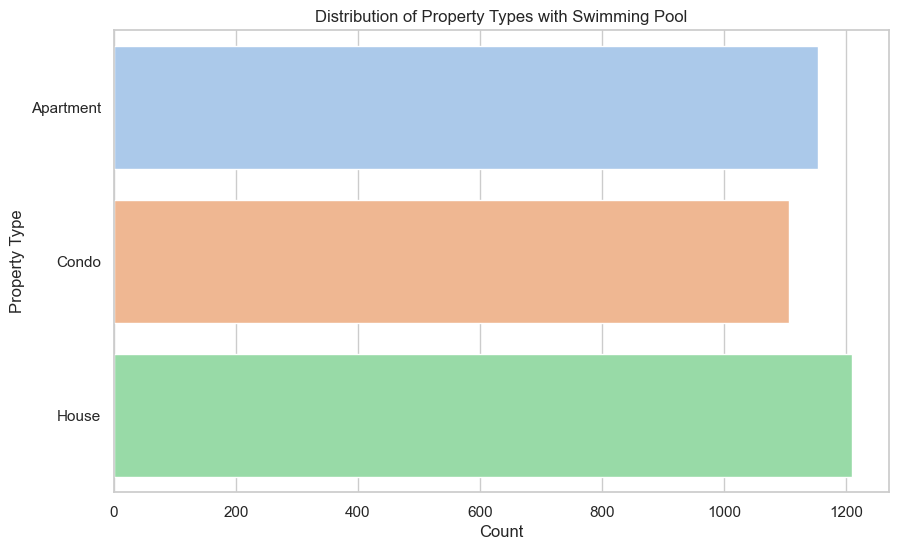

In [48]:
# 6. Distribution of Property Types with Swimming Pool
with_swimming_pool = df.filter("amenities LIKE '%Swimming Pool%'").groupBy("property_type").count().toPandas()
plt.figure(figsize=(10, 6))
sns.barplot(x="count", y="property_type", data=with_swimming_pool, palette="pastel")
plt.title("Distribution of Property Types with Swimming Pool")
plt.xlabel("Count")
plt.ylabel("Property Type")
plt.show()
